# DPGMM Truncated Variational Inference

In [28]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd = tfp.distributions
tf.enable_eager_execution()

In [106]:
from scipy.special import digamma as dgm

### Data Generation and Visulaization

In [1092]:
# Data Generation 
data = None

num_clusters  =  6
num_points = 1000
scale = 3
scale_dist = 0.2
means = tfd.Normal(loc=[0,0], scale=scale).sample(num_clusters).numpy()
for cluster in range(num_clusters):
    cluster_mean = means[cluster]
    dist = tfd.Normal(loc=cluster_mean, scale=scale_dist)
    curr_data = dist.sample(20).numpy()
    if(data is None):
        data = curr_data
    else:
        data = np.vstack([data,curr_data])

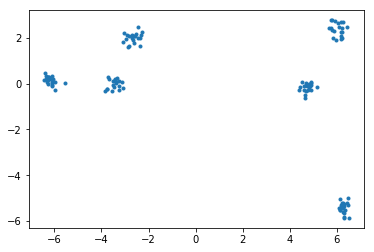

In [1093]:
plt.plot(data[:,0], data[:,1], '.')

### Truncated Variaitonal Inference ( BleiJordan 2004 )

In [1308]:
# Setting a truncation level
truncation_level = 10
gamma1s = [] # Beta param 1
gamma2s = [] # Beta param 2
tou1s = [] # mu_t
tou2s = [] # sigma_t
scale_init = 10

# Hyper params
alpha = 1
mu0 = np.array([0,0]).reshape(1,-1)
sigma0 = np.array([100]).reshape(1,-1)

# Random initializations
for i in range(truncation_level):
    curr_gamma1 = np.random.uniform(0.1,1)*0 + alpha
    curr_gamma2 = np.random.uniform(0.1,1)*0 + alpha
    curr_tou1 = np.array([np.random.rand()*scale_init, np.random.rand()*scale_init]).reshape(1,-1)
    curr_tou2 = np.array([1]).reshape(1,-1)
    
    gamma1s.append(curr_gamma1)
    gamma2s.append(curr_gamma2)
    tou1s.append(curr_tou1)
    tou2s.append(curr_tou2)

    
N, D = data.shape
Z = np.random.randint(0,truncation_level,size = [N])

In [1309]:
# Inference using Mean Field Assumption

def cavi_step():
    
    global phis
    # Temp Parameters will only be used at inferencing time
    phis = np.random.rand(N,truncation_level)**2
    phis = phis/np.sum(phis, axis=1).reshape(-1,1)
    E_log_Vi = np.zeros((truncation_level))
    E_log_1mVi = np.zeros((truncation_level))
    likc = np.zeros(truncation_level)
    
    for t in range(truncation_level):
        
        
            
        if(t != truncation_level-1):
            E_log_Vi[t] = dgm(gamma1s[t]) - dgm(gamma1s[t] + gamma2s[t])
            E_log_1mVi[t] = dgm(gamma2s[t]) - dgm(gamma1s[t] + gamma2s[t])
            likc[t] = E_log_Vi[t] + np.sum(E_log_1mVi[:t]) 
        else:
            likc[-1] = np.log(1 - (sum(np.exp(likc[:-1]))))
        
        for n in range(N):
            
            x_n = data[n,:].reshape(1,-1)    
            
            delta = x_n - tou1s[t]
            sigma_sqr = tou2s[t]
            S_t = likc[t]  - 0.5*(D*np.log(sigma_sqr) + np.dot(delta,delta.T)/sigma_sqr) 
            
            phis[n,t] = S_t
        
        
    phis = phis - np.max(phis, axis = 1).reshape(-1,1)
    logsumexp = np.log(np.sum(np.exp(phis), axis = 1)).reshape(-1,1)
    phis = np.exp(phis - logsumexp)
    phis = phis + 10e-12
    phis = phis/np.sum(phis, axis=1).reshape(-1,1)
    
    
    for t in range(truncation_level):
        
        gamma1s[t] = 1 + np.sum(phis[:,t])
        gamma2s[t] = alpha  + np.sum(np.sum(phis[:,t:]))
            
        
        tou1s[t] = (sigma0*np.sum(phis[:,t].reshape(N,-1)*data, axis = 0) + tou2s[t]*mu0)/(tou2s[t] + sigma0*np.sum(phis[:,t]))
        tou2s[t] = 1# + (tou2s[t]*sigma0)/(tou2s[t] + sigma0*np.sum(phis[:,t]))
    
    return phis

In [1310]:
for epoch in range(50):
    phis = cavi_step()

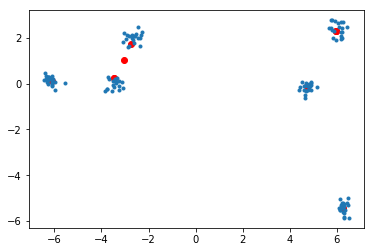

In [1311]:
for t in range(truncation_level):
    vec = tou1s[t]
    plt.plot(vec[0,0], vec[0,1], 'r.', markersize =12)
plt.plot(data[:,0], data[:,1], '.')
plt.show()

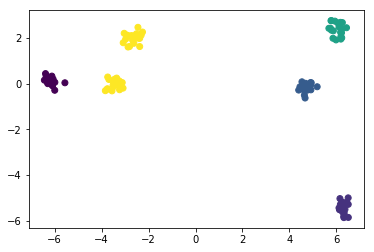

In [1312]:
Z = np.argmax(phis,axis = 1)
plt.scatter(data[:,0],data[:,1],c = Z)

### Thankyou
Abhishek Kumar